In [1]:
import test_load

import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
model_save_dir = "models/"

In [3]:
image_size = 8
test_arr, image_names = test_load.get_test_subsmission(image_size)

In [4]:
def load_models(model_dir, model_name):
    model = tf.keras.models.load_model(f'{model_dir}{model_name}')
    idx_file = pd.read_csv(f'{model_dir}idx_class.csv')
    return model, idx_file

In [5]:
superclass_dir = f"{model_save_dir}superclass/"
superclass_model = "superclass_Conv2DTranpose"

subclass_dir = f"{model_save_dir}subclass/"

subclass_model_0 = "subclass_Conv2DTranpose_0"
subclass_model_1 = "subclass_Conv2DTranpose_1"
subclass_model_2 = "subclass_Conv2DTranpose_2"

In [6]:
super_model, super_idx = load_models(superclass_dir, superclass_model)

In [7]:
subclass_0_model, subclass_0_idx = load_models(subclass_dir+"0/", subclass_model_0)
subclass_1_model, subclass_1_idx = load_models(subclass_dir+"1/", subclass_model_1)
subclass_2_model, subclass_2_idx = load_models(subclass_dir+"2/", subclass_model_2)

In [8]:
softmax = tf.nn.softmax

In [17]:
y_super = []
y_sub = []

threshold = .75

arr = test_arr.reshape(-1,image_size,image_size,3)
y_superclass = softmax(super_model.predict(arr, verbose = 0), axis = 1)


subclass_0_l = softmax(subclass_0_model.predict(arr, verbose = 0), axis = 1)
subclass_1_l = softmax(subclass_1_model.predict(arr, verbose = 0), axis = 1)
subclass_2_l = softmax(subclass_2_model.predict(arr, verbose = 0), axis = 1)


for idx in range(len(y_superclass)):
    subclass_name = None
    super_prob = np.array(y_superclass[idx])
    
    subclass_0 = subclass_0_l[idx]*super_prob[0]
    subclass_1 = subclass_1_l[idx]*super_prob[1]
    subclass_2 = subclass_2_l[idx]*super_prob[2]
    
    max_subclass = 0
    if (np.max(subclass_1) > np.max(subclass_0)) and (np.max(subclass_1) > np.max(subclass_2)):
        max_subclass = 1
    elif (np.max(subclass_2) > np.max(subclass_0)) and (np.max(subclass_2) > np.max(subclass_1)):
        max_subclass = 2
    
    
    if max_subclass == 0:
        idx = np.argmax(subclass_0)
        sub_prob = subclass_0[idx]
        subclass_name = list(subclass_0_idx[subclass_0_idx['index'] == idx]['name'])[0] \
                        if sub_prob > threshold else 89    
    elif max_subclass == 1:
        idx = np.argmax(subclass_1)
        sub_prob = subclass_1[idx]
        subclass_name = list(subclass_1_idx[subclass_1_idx['index'] == idx]['name'])[0] \
                        if sub_prob > threshold else 89
    elif max_subclass == 2:
        idx = np.argmax(subclass_2)
        sub_prob = subclass_2[idx]
        subclass_name = list(subclass_2_idx[subclass_2_idx['index'] == idx]['name'])[0] \
                        if sub_prob > threshold else 89
        
    y_super.append(max_subclass)
    y_sub.append(subclass_name)  

In [18]:
dic = {'img':image_names , 'prediction_index':y_sub}

df = pd.DataFrame.from_dict(dic)
df['img'] = df['img'].apply(lambda x: int(x.replace('.jpg','')))
df = df.sort_values('img').reset_index(drop=True)

map = pd.read_csv('Realesed Data/sub_classes_mapping.csv')
your_pred_list = df['prediction_index'].tolist()

map_dict = {}
for index , row in map.iterrows():
    map_dict[index] = row[1]

submission = []
for index in your_pred_list:
    submission.append(map_dict[index])

res = pd.DataFrame({'predictions': submission})
res.to_csv('sub_submission.csv', index=False)

<AxesSubplot: xlabel='predictions'>

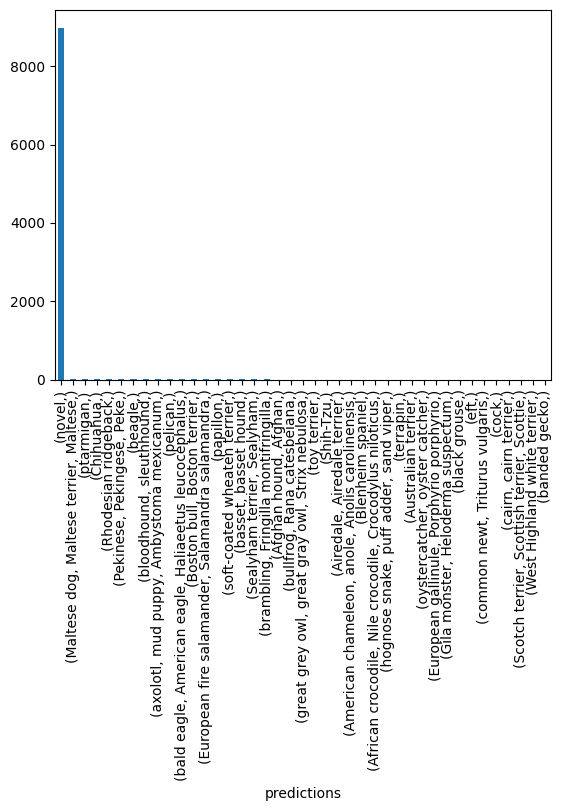

In [19]:
res.value_counts().plot(kind='bar')